## Imports and Preparations

In [ ]:
%%capture
!pip install datasets

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
from transformers import AutoModel, AutoTokenizer, Trainer, TrainingArguments, DataCollatorForLanguageModeling
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from torch.utils.data import DataLoader
from tqdm import tqdm
from datasets import Dataset
from datasets import load_dataset
import matplotlib.pyplot as plt
import os
from sklearn.metrics import r2_score
import csv



### Part 1



## Initialization of models / datasets

In [ ]:
DATASET_PATH = "scikit-fingerprints/MoleculeNet_Lipophilicity"
MODEL_NAME = "ibm/MoLFormer-XL-both-10pct"
EXTERNAL_DATA_PATH = "External-Dataset_for_Task2.csv"#task to the external dataset (change accordingly)

In [ ]:
ext_data = pd.read_csv(EXTERNAL_DATA_PATH)
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, trust_remote_code=True)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [ ]:
# specify model with a regression head
class MoLFormerWithRegressionHead(nn.Module):
    def __init__(self, model):
        super(MoLFormerWithRegressionHead, self).__init__()
        self.model = model
        self.dropout = nn.Dropout(0.2)
        self.regression_head = nn.Linear(model.config.hidden_size, 1)

    def forward(self, inputs, attention_mask):
        output = self.model(inputs, attention_mask)
        pooled_output = output.last_hidden_state[:, 0, :]
        pooled_output = self.dropout(pooled_output)
        return self.regression_head(pooled_output)


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Load the pre-trained model and tokenizer
model = AutoModel.from_pretrained(MODEL_NAME, deterministic_eval=True, trust_remote_code=True).to(device)
regression_model = MoLFormerWithRegressionHead(model).to(device)
regression_model.load_state_dict(torch.load("/content/drive/MyDrive/nnti/model_epoch_regression_finetune_5.pth"), strict=False)# path to the fine tuned pre trained MLM from task 1

regression_model

<ipython-input-7-d850e40533c9>:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  regression_model.load_state_dict(torch.load("/content/drive/MyDrive/nnti/model_epoch_regressi

MoLFormerWithRegressionHead(
  (model): MolformerModel(
    (embeddings): MolformerEmbeddings(
      (word_embeddings): Embedding(2362, 768, padding_idx=2)
      (dropout): Dropout(p=0.2, inplace=False)
    )
    (encoder): MolformerEncoder(
      (layer): ModuleList(
        (0-11): 12 x MolformerLayer(
          (attention): MolformerAttention(
            (self): MolformerSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (rotary_embeddings): MolformerRotaryEmbedding()
              (feature_map): MolformerFeatureMap(
                (kernel): ReLU()
              )
            )
            (output): MolformerSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      

## Data Preparation

In [ ]:
def tokenize_smiles(smiles, label):
    tokenized = tokenizer(smiles,
                          return_tensors="pt",
                          padding=True,
                          truncation=True,
                          max_length=300)
    return {
        'input_ids': tokenized['input_ids'].squeeze(0),
        'attention_mask': tokenized['attention_mask'].squeeze(0),
        'target': torch.tensor(label, dtype=torch.float32)
    }


def load_training_data():
    """Load the original Lipophilicity training dataset."""
    train_df = pd.DataFrame(load_dataset(DATASET_PATH)['train'])

    return [tokenize_smiles(row['SMILES'], row['label']) for _, row in train_df.iterrows()]

# Load training dataset using the updated function
train_data = load_training_data()


In [ ]:
#split
train_data_split, test_data_split = train_test_split(train_data, test_size=0.2, random_state=42)

In [ ]:
ext_data.head()

,SMILES,Label
0,CCCCN1Cc2c(nc3cc(-c4ccco4)nn3c2O)C1=O,1.548
1,Cc1cc(C)c2c(n1)sc1c2ncnc1N1CCN(C)CC1,2.568
2,COC(=O)[C@H]1[C@H]2CC[C@H](C[C@@H]1OC(=O)c1ccc...,0.102
3,Nc1nonc1/C(=N/O)Nc1ccc(F)c(Cl)c1,2.450
4,Cc1c[nH]c(/C=C2/C(=O)Nc3ccccc32)c1CCC(=O)O,1.040


In [ ]:
def prepare_datapoint(train_sample):
  tokenized = tokenize_smiles(train_sample['SMILES'], train_sample['Label'])
  inputs = {key: val.unsqueeze(0) for key, val in tokenized.items()}
  return inputs

## Gradient Calculation

In [ ]:
regression_model.eval()

def compute_gradients(model, train_sample, loss_fn):

    model.zero_grad()  # Reseting gradients

    input_ids, attention_mask, targets = train_sample['input_ids'].to(device), train_sample['attention_mask'].to(device), train_sample['target'].to(device)
    outputs = model(input_ids, attention_mask)

    # Calculate MSE loss
    loss = loss_fn(outputs, targets)

    # Backward pass
    loss.backward()

    # Collecting gradients
    gradients = [param.grad for param in model.parameters()]

    return gradients

## Lissa Approximation

In [ ]:
def lissa_approximation(model, test_gradient, train_data, loss_fn, dataset, length, iters, damping_factor):
    """Approximation of inverse Hessian-vector product using LiSSA algorithm."""
    iHvp = test_gradient
    for _ in range(iters):

        # Select random indices to reduce bias
        random_idx = np.random.randint(length)
        train_sample = train_data[random_idx]

        # Extract input tensors and labels from train_sample
        input_ids = train_sample['input_ids'].unsqueeze(0).to(device)
        attention_mask = train_sample['attention_mask'].unsqueeze(0).to(device)
        targets = train_sample['target'].unsqueeze(0).to(device)

        prepared_input = {
            'input_ids': input_ids,
            'attention_mask': attention_mask,
            'target': targets
        }

        # Compute gradients on the training value
        train_grad = compute_gradients(model, prepared_input, loss_fn)

        # Calculate iHvp
        iHvp = [t - damping_factor * index for t, index in zip(train_grad, iHvp)]

    return iHvp

## Influence score calculation


In [ ]:
def compute_influence_scores(model, tokenizer, external_data, train_data, loss_fn):
    influence_scores = []

    for _, row in tqdm(external_data.iterrows(), total=len(external_data)):


        inputs = prepare_datapoint(row)

        # Compute test gradient
        test_gradient = compute_gradients(regression_model, inputs, loss_fn)


        # Approximate inverse Hessian-vector product
        iHvp = lissa_approximation(model, test_gradient, train_data,
                                   loss_fn, train_data, len(train_data_split), 100, 0.01)

        # # Compute influence score as dot product of test gradient and inverse Hessian Vector Product
        influence = 0
        for tg, ih in zip(test_gradient, iHvp):
            influence += torch.dot(tg.flatten(), ih.flatten()).item()

        # #Create influence scores list
        influence_scores.append((row['SMILES'], row['Label'], influence))

    return sorted(influence_scores, key=lambda x: x[1], reverse=True)


In [ ]:
# Compute influence scores
loss_fn = torch.nn.MSELoss()
influence_scores = compute_influence_scores(regression_model, tokenizer, ext_data, train_data_split, loss_fn)


In [ ]:
# # Select top-K influential samples
TOP_K = 128
selected_samples = influence_scores[:TOP_K]

NameError: name 'influence_scores' is not defined

## Exporting the influence scores in a csv

In [ ]:
# Assuming influence_scores is a list of tuples (SMILES, Label, Influence)
influence_df = pd.DataFrame(influence_scores, columns=['SMILES', 'Label', 'Influence'])
influence_df.to_csv("influence_scores.csv", index=False)

NameError: name 'influence_scores' is not defined

## Fine Tuning the model

In [ ]:
finetuning_model = MoLFormerWithRegressionHead(model).to(device)
finetuning_model.load_state_dict(torch.load("/content/drive/MyDrive/nnti/model_epoch_regression_finetune_5.pth"), strict=False)

finetuning_model

<ipython-input-12-f6a4a06246a0>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  finetuning_model.load_state_dict(torch.load("/content/drive/MyDrive/nnti/model_epoch_regress

MoLFormerWithRegressionHead(
  (model): MolformerModel(
    (embeddings): MolformerEmbeddings(
      (word_embeddings): Embedding(2362, 768, padding_idx=2)
      (dropout): Dropout(p=0.2, inplace=False)
    )
    (encoder): MolformerEncoder(
      (layer): ModuleList(
        (0-11): 12 x MolformerLayer(
          (attention): MolformerAttention(
            (self): MolformerSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (rotary_embeddings): MolformerRotaryEmbedding()
              (feature_map): MolformerFeatureMap(
                (kernel): ReLU()
              )
            )
            (output): MolformerSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      

**while running whole notebook uncomment this and comment the next block**

In [ ]:
# Sort the DataFrame by the 'Influence' column in descending order / while running whole notebook uncomment this
# sorted_df = influence_df.sort_values(by=['Influence'], ascending=False)
# df = sorted_df

**while using the influence_scores.csv file use this block and comment the previous block**




In [ ]:
# Use the influence scores csv and sort them
with open("influence_scores (1).csv", mode="r", encoding="utf-8") as file:
    reader = csv.DictReader(file)
    data = list(reader)

# Sort the data by the third column in descending order
third_column_name = list(data[0].keys())[2]  # influence score
sorted_data = sorted(data, key=lambda x: float(x[third_column_name]), reverse=True)

df = pd.DataFrame(sorted_data)

In [ ]:
# Create a Hugging Face Dataset from the top 64 values
selected_dataset = Dataset.from_pandas(df[['SMILES', 'Label']].head(128))

print(selected_dataset)
labels_list = [float(label) for label in selected_dataset['Label']]

# Tokenize the dataset
tokenized_selected_dataset = [
    tokenize_smiles(smiles, label) for smiles, label in zip(selected_dataset['SMILES'], labels_list)
]

data_collator = DataCollatorForLanguageModeling(
    tokenizer=tokenizer,
    mlm=False,
    mlm_probability=0.15
)

# Create PyTorch dataloaders
train_dataloader = DataLoader(tokenized_selected_dataset, batch_size=16, shuffle = True, collate_fn = data_collator)

Dataset({
    features: ['SMILES', 'Label'],
    num_rows: 128
})




### Part 2



**Fine-tuning**

Epoch 5: 100%|██████████| 8/8 [00:01<00:00,  7.67it/s]


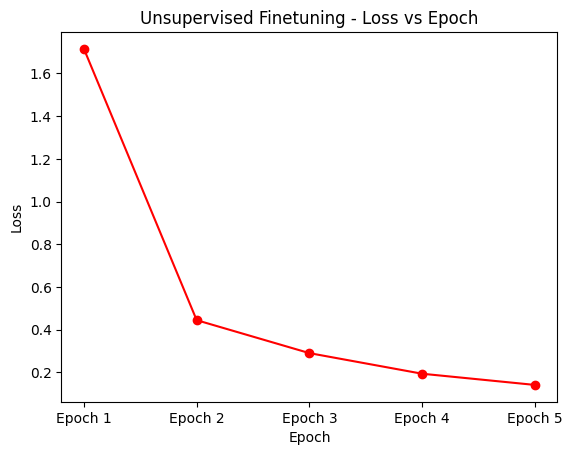

In [ ]:
def t_finetune(model, epochs, tokenizer, train_data_loader):
  mlm_model = model
  loss_fn = torch.nn.MSELoss()

  optimizer = torch.optim.AdamW(mlm_model.parameters(), lr=1e-4)
  # SAVE_PATH = "/content/model_checkpoints/finetuning_task2"
  # os.makedirs(SAVE_PATH, exist_ok=True)

  epochs_names = []
  epochs_lossses = []


  mlm_model.train()
  for epoch in range(epochs):
      total_loss = 0
      for batch in tqdm(train_data_loader, desc=f"Epoch {epoch+1}"):
            input_ids, attention_mask, target = batch['input_ids'].to(device), batch['attention_mask'].to(device), batch['target'].to(device)

            optimizer.zero_grad()
            outputs = mlm_model(input_ids, attention_mask)
            loss = loss_fn(outputs.squeeze(1), target)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()


      epochs_lossses.append(total_loss / len(train_data_loader))
      epochs_names.append(f'Epoch {epoch+1}')


  plt.plot(epochs_names, epochs_lossses, label="Train Loss", color='red', marker='o')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.title('Unsupervised Finetuning - Loss vs Epoch')
  plt.show()

  return mlm_model

epochs = 5
fine_tuned_model = t_finetune(finetuning_model, epochs, tokenizer, train_dataloader)

In [ ]:
def evaluate_model(test_data_loader, model):
  mlm_model = model
  mlm_model.eval()
  loss_fn = torch.nn.MSELoss()
  optimizer = torch.optim.AdamW(mlm_model.parameters(), lr=1e-4)
  mse_loss = torch.nn.MSELoss()
  total_loss = 0
  targets_values = []
  predictions_values = []



  with torch.no_grad():

        for batch in tqdm(test_data_loader):
            input_ids, attention_mask, target = batch['input_ids'].to(device), batch['attention_mask'].to(device), batch['target'].to(device)

            outputs = mlm_model(input_ids.unsqueeze(0), attention_mask.unsqueeze(0))
            loss = mse_loss(outputs.squeeze(1), target.unsqueeze(0))

            predictions_values.extend(outputs.cpu().detach().numpy().flatten())
            targets_values.extend(target.cpu().numpy().flatten())
            total_loss += loss.item()


  print(f"\nLoss : {total_loss / len(test_data_loader)}")
  print(f"R2 : {r2_score(targets_values, predictions_values)}")

In [ ]:
evaluate_model(test_data_split, finetuning_model)

100%|██████████| 840/840 [00:14<00:00, 57.25it/s]


Loss : 1.4620978176381727
R2 : 0.0104073977393776
